# Tonal Descriptors: Pitch and Chroma

Load *Zigeunerweisen* by Pablo de Sarasate.

In [67]:
from urllib import urlretrieve
urlretrieve('https://ccrma.stanford.edu/workshops/mir2014/audio/prelude_cmaj_10s.wav', filename='prelude_cmaj_10s.wav')
urlretrieve('https://ccrma.stanford.edu/workshops/mir2014/audio/T08-violin-8k.wav', filename='violin.wav')

from essentia.standard import MonoLoader
audio = MonoLoader(filename='violin.wav')()

from IPython.display import Audio
fs = 44100.0
Audio(audio, rate=fs)

Compute onsets, play audio signal with onsets superimposed.

In [68]:
from essentia.standard import PitchSalience, PredominantMelody, \
        PitchYinFFT, FrameGenerator, OnsetRate, AudioOnsetsMarker, \
        HPCP, TuningFrequency, Key, ChordsDetection, ChordsDescriptors

onset_gen = OnsetRate()
onset_times, onset_rate = onset_gen(audio)
onset_samples = (onset_times*fs).astype(int)
#print onset_times
#print onset_rate
aom = AudioOnsetsMarker(onsets=onset_times)
audio_with_onsets = aom(audio)

Audio(audio_with_onsets, rate=fs)

Compute a pitch for each onset-bounded segment.

In [69]:
from essentia.standard import Spectrum
spectrum = Spectrum()

bounds = append(onset_times, (len(audio)/fs))
print bounds.shape
print type(bounds)
bounds_samples = (bounds*fs).astype(int)

pitches = []

def hz2midi(hz):
    return 69 + 12*log2(hz/440.0)

for i in range(len(bounds)-1):
    seg_start = bounds_samples[i]
    seg_end = bounds_samples[i+1]
    seg = audio[seg_start:seg_end]
    frame_sz = len(seg)
    
    if frame_sz % 2 == 1:
        seg = seg[:-1]
        frame_sz = len(seg)
    
    yin = PitchYinFFT(frameSize = frame_sz)
    pitch, pitch_conf = yin(spectrum(seg))
    pitches.append([pitch, frame_sz])

midi_pitches = [[hz2midi(f[0]), f[1]/fs] for f in pitches]
#print midi_pitches

(33,)
<type 'numpy.ndarray'>


Synthesize a new signal comprised of pure sinusoids using the extracted midi pitch values and note durations.

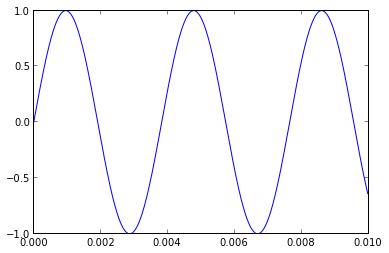

In [70]:
def midi2hz(midi):
    return 440*2**((midi-69)/12.0)

def synth(midi, T, fs):
    
    f0 = midi2hz(midi)
    #print midi, f0
    N = int(T*fs)
    n = arange(N)
    t = n/float(fs)
    return t, sin(2*pi*f0*t)

t, y = synth(60, 0.01, fs)
plot(t, y)

z = concatenate([synth(int(p[0]), p[1], fs)[1] for p in midi_pitches])

audio_trim = audio[len(audio)-len(z):]
z_stereo = array([z, audio_trim])
#print z.shape, type(z)
#print audio.shape
#print audio_trim.shape, type(audio_trim)
#print z_stereo.shape
Audio(z_stereo.sum(axis=0), rate=fs)